In [86]:
from json import load
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from glob import glob
%matplotlib inline

In [87]:
glob("*.json")

['e68b03ff-4c6a-4c86-b4e9-d41d39160d9b.json',
 '8beea9d8-2167-4f7d-b140-56bab55bf2aa.json']

In [88]:
meta = load(open(glob("*.json")[0]))

In [89]:
grid = meta['grid']
iscale = meta['scale']

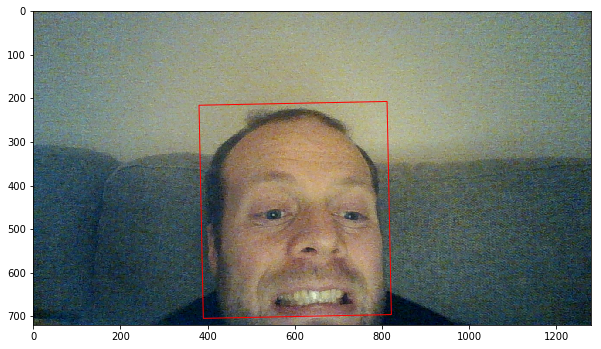

In [91]:
im = plt.imread(glob("*.png")[0])
scale = im.shape[1]/iscale
fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(im)
rect = mpatches.Rectangle((grid['left']*scale,grid['top']*scale),width=grid['width']*grid['scaleX']*scale,height=grid['height']*grid['scaleY']*scale,angle=grid['angle'],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [83]:
scale

1.6644993498049414

In [79]:
im.resize

0.60078125